# Example of nonlinear regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels as sm

## Quick exploration of the data

In [2]:
# data from page 367
norepi_log = np.arange(-8, -2.5, .5) # log scale
relaxation = np.array([2.6, 10.5, 15.8, 21.1, 36.8, 57.9, 73.7, 89.5, 94.7, 100, 100])

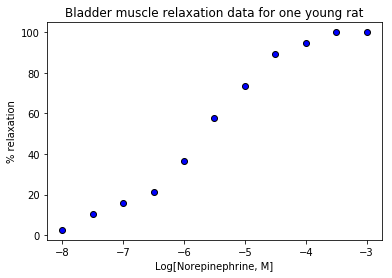

In [3]:
plt.plot(norepi_log, relaxation, 'ko', mfc='blue')
plt.title("Bladder muscle relaxation data for one young rat")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel("% relaxation");

## Fitting the model

$$
Y = Bottom + \frac{Top - Bottom}{1 + 10^{(LogEC_{50} - X).HillSlope}}
$$

After choosing a model, the next step is to decide which of the parameters in the model should be fit to the data and which should be fixed to constant values. In this case, muscle relaxation must be zero with no added norepinephrine. So we will tell the model not to find the best-fit value of Bottom but rather to set it to a constant value of zero. We don't want to fix the top to 100, because the one goal of the study is to see whether that top plateay differs in old and young rats.

In [4]:
from scipy.optimize import curve_fit

In [5]:
def logistic3(x, top, ec50, hill_slope):
    """3PL logistic equation"""
    return (0 + ((top - 0) / (1 + 10**((ec50 - x) * hill_slope))))

def logistic4(x, top, bottom, ec50, hill_slope):
    """4PL logistic equation - Used when bottom != 0"""
    return (bottom + ((top - bottom) / (1 + 10**((ec50 - x) * hill_slope))))

# initial guess for parameters
p0 = [100, -6, .5] # top, ec50, hill_slope


# fit the model equation 3PL to the data using least squares optimization
best_vals, covar = curve_fit(logistic3, norepi_log, relaxation, p0=p0)
print(best_vals)

[104.05305746  -5.63808944   0.62209876]


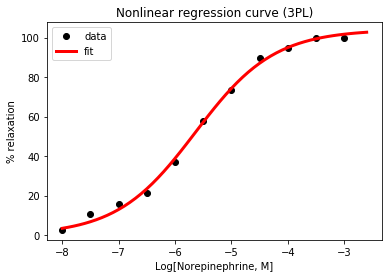

In [6]:
plt.plot(norepi_log, relaxation, 'ko', label='data') # original data points

x=np.arange(-8, -2.5, step=.1)
plt.plot(x, logistic3(x, *best_vals), 'r-', lw=3, label='fit')
plt.title("Nonlinear regression curve (3PL)")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel("% relaxation")
plt.legend();

In [7]:
10**(best_vals[1]) # corresponds to EC50 = 2.3 µM

2.300967897192361e-06

### Confidence interval estimation

Prism uses a standard method to compute the standard error and confidence interval for each parameter fit with nonlinear regression. Each parameter's standard error is computed using this equation:
$$SE(P_i) = \sqrt{(SS/DF) * Cov_{i,i}}$$
where:
$P_i$ : i-th adjustable(non-constant) parameter
$SS$ : sum of squared residuals
$DF$ : degrees of freedom (the number of data points minus number of parameters fit by regression)
$Cov(_i,_i)$ : i-th diagonal element of covariance matrix

Asymptotic confidence intervals are always centered on the best-fit value of the parameter, and extend the same distance above and below that value. The 95% confidence intervals are computed by this equation:

FROM $[BestFit- t*SE]$  TO  $[BestFit+ t*SE]$

where $BestFit$ is the best fit value for the parameter, $SE$ is its standard error,  and $t$ is the value from the t distribution for the desired level of confidence (95% is standard) and the number of degrees of freedom (which equals the number of data points minus the number of parameters fit by regression). With 95% confidence and many degrees of freedom (more than a few dozen), this multiplier is very close to 1.96. Note that the value of t is not computed from your data, but is a constant that depends on the confidence level you choose, the number of data points, and the number of parameters.

In [8]:
covar

array([[ 4.24161009e+00,  8.27167161e-02, -5.12799761e-02],
       [ 8.27167161e-02,  2.65400288e-03, -9.97677693e-04],
       [-5.12799761e-02, -9.97677693e-04,  1.28149795e-03]])

covar is the estimated covariance of best_val. The diagonals provide the variance of the parameter estimate. To compute one standard errors on the estimated coefficients use `perr = np.sqrt(np.diag(covar))`

$$
\sum cov=\left[ \begin{array}{}
\sigma² & cov \\
cov & \sigma² \\ \end{array} \right]
$$
In the current case, $covar$ is the covariance matrix (inverted Hessian from last iteration), or covariance of the parameters around the optimal values. See also https://www.graphpad.com/guides/prism/7/curve-fitting/index.htm?reg_how_confidence_and_prediction_.htm
Therefore this is not the covariance matrix of the variables, but of the estimated parameters, with $\sigma²$ the variance of the errors around the mean of the predicted points on the OLS line (noise)
$$Var(\hat{\beta})=\sigma²(X^{T}X)^{-1}$$
$$\sigma²=\frac{1}{df}\sum(residuals)²$$

In [9]:
np.sqrt(np.diag(covar)) # this returns the so-called standard error (see Intuitive Biostatistics)

array([2.05951695, 0.05151702, 0.03579802])

In [10]:
perr = np.sqrt(np.diag(covar)) # it looks like the 1-sigma of this matrix is the SE
n = len(norepi_log)
p = len(best_vals) # number of parameters fitted

In [11]:
df = n - p # n data points minus parameters fitted
t_ = stats.t(df=df).ppf((1+.95)/2) # two-tailed

def return_ci(estimate, se):
    return (estimate-t_*se, estimate+t_*se)

print(f"95% CI for 'top' parameter: {return_ci(best_vals[0], perr[0])}")
print(f"95% CI for 'EC50' parameter: {return_ci(best_vals[1], perr[1])}")
print(f"95% CI for 'Hill slope' parameter: {return_ci(best_vals[2], perr[2])}")

95% CI for 'top' parameter: (99.30380284627736, 108.80231207460483)
95% CI for 'EC50' parameter: (-5.756887891216683, -5.519290989802805)
95% CI for 'Hill slope' parameter: (0.5395483822401705, 0.7046491283178209)


### Curve-fitting with lmfit library

In [12]:
from lmfit import Model

In [23]:
gmodel = Model(logistic3)
gmodel.param_names

['top', 'ec50', 'hill_slope']

In [24]:
# set the initial values for parameters with **args
params = gmodel.make_params(top=100, ec50=-5, hill_slope=.6)

In [25]:
results = gmodel.fit(relaxation, x=norepi_log, params=params) # y parameter first!

In [26]:
print(results.fit_report())

[[Model]]
    Model(logistic3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 11
    # variables        = 3
    chi-square         = 42.9570499
    reduced chi-square = 5.36963124
    Akaike info crit   = 20.9853605
    Bayesian info crit = 22.1790464
[[Variables]]
    top:         104.053067 +/- 2.05950530 (1.98%) (init = 100)
    ec50:       -5.63808917 +/- 0.05151681 (0.91%) (init = -5)
    hill_slope:  0.62209862 +/- 0.03579814 (5.75%) (init = 0.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(top, ec50)        =  0.780
    C(top, hill_slope)  = -0.696
    C(ec50, hill_slope) = -0.541



In [17]:
results.params['top'].value

104.0530667445461

In [18]:
results.params

Parameters([('top',
             <Parameter 'top', value=104.0530667445461 +/- 2.06, bounds=[-inf:inf]>),
            ('ec50',
             <Parameter 'ec50', value=-5.638089169153799 +/- 0.0515, bounds=[-inf:inf]>),
            ('hill_slope',
             <Parameter 'hill_slope', value=0.6220986160835926 +/- 0.0358, bounds=[-inf:inf]>)])

In [19]:
print(results.ci_report(with_offset=False))

               99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 top       :  96.26337  99.55253 101.95430 104.05307 106.29220 109.26004 114.26127
 ec50      :  -5.83994  -5.75227  -5.69059  -5.63809  -5.58330  -5.51218  -5.39524
 hill_slope:   0.48517   0.54229   0.58471   0.62210   0.66215   0.71515   0.80315


### Graphs

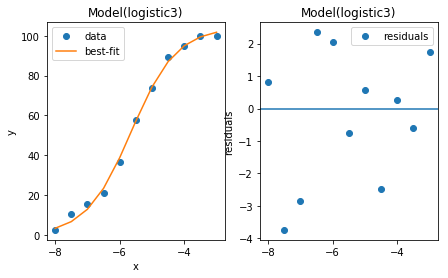

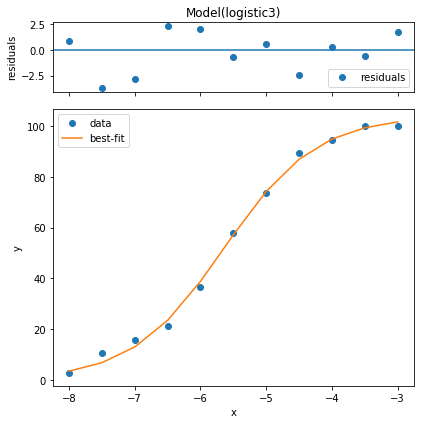

In [27]:
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
results.plot_fit() # ATTENTION every time we refit the model, parameters change
plt.subplot(1,2,2)
results.plot_residuals()

results.plot() # make both residual and model_fit plots
plt.tight_layout();

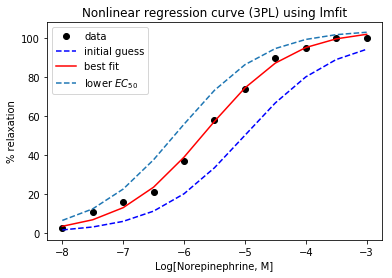

In [20]:
plt.plot(norepi_log, relaxation, 'ko', label='data') # original data points

plt.plot(norepi_log, results.init_fit, 'b--', label='initial guess')
plt.plot(norepi_log, results.best_fit, 'r-', label='best fit')
plt.plot(norepi_log, results.eval(top=104, ec50=-6.1, hill_slope=.622),
        '--', label='lower $EC_{50}$') # evaluation of parameters
plt.title("Nonlinear regression curve (3PL) using lmfit")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel("% relaxation")
plt.legend();

### Goodness of fit

In [28]:
print(f"Absolute sum of squares (Chi-square):{(results.residual**2).sum():3.1f}")

Absolute sum of squares (Chi-square):43.0


In [29]:
def compute_rss(y_estimate, y): 
  return sum(np.power(y - y_estimate, 2)) 

rss = compute_rss(results.best_fit, relaxation)
tss = np.sum(np.power(relaxation - np.mean(relaxation), 2))
print(f"R square using TSS and RSS: {(tss-rss)/tss}")

R square using TSS and RSS: 0.9971202652833819


R² is the fraction of the total variance of Y that is explained by the model. In this example, the curve comes very close to all the data points, so the R² is very high.

## Bootstrapping

In [57]:
params = gmodel.make_params(top=100, ec50=-5, hill_slope=.6)
results = gmodel.fit(relaxation, x=norepi_log, params=params) # need to rerun fit to erase last parameters

# bootstrapping starts here:
size=10000
inds = np.arange(len(norepi_log))
bs_top_reps = np.empty(size)
bs_ec50_reps = np.empty(size)
bs_hill_slope_reps = np.empty(size)
  
for _ in range(size):
    bs_inds = np.random.choice(inds, len(inds))
    bs_x, bs_y = norepi_log[bs_inds], relaxation[bs_inds]
    results.fit(bs_y, x=bs_x, params=params)
    bs_top_reps[_] = results.params['top'].value
    bs_ec50_reps[_] = results.params['ec50'].value
    bs_hill_slope_reps[_] = results.params['hill_slope'].value

In [58]:
np.percentile(bs_top_reps, [2.5, 97.5])

array([1.01715707e+02, 6.67488632e+07])

In [59]:
np.percentile(bs_ec50_reps, [2.5, 97.5])

array([ -5.71800717, 150.10910291])

In [60]:
np.percentile(bs_hill_slope_reps, [2.5, 97.5])

array([0.23449334, 0.7053197 ])

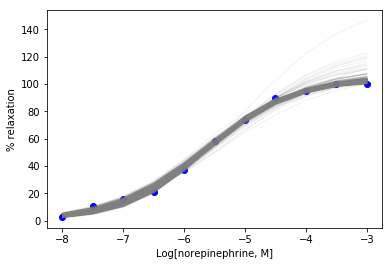

In [61]:
# plt the 500 first pairs of parameters
plt.plot(norepi_log, relaxation, 'bo', linestyle='None')

for _ in range(500):
    plt.plot(norepi_log, logistic3(norepi_log, bs_top_reps[_],
                                         ec50=bs_ec50_reps[_],
                                         hill_slope=bs_hill_slope_reps[_]),
                 color='grey', lw=1, alpha=.1)
    
plt.xlabel('Log[norepinephrine, M]')
plt.ylabel('% relaxation');

## Comparing models

We compare the fit of two dose-response models. The second curve represent a fit by a simpler model in which the Hill slope was fixed to a standard value of 1.0. The residuals from the fixed-slope model are much larger and not random. In contrast the residuals from the variable slope model are smaller and random (no obvious pattern).

In [62]:
x = np.arange(-8, -2.5, .5) # log scale
y = np.array([2.6, 10.5, 15.8, 21.1, 36.8, 57.9, 73.7, 89.5, 94.7, 100, 100])

In [63]:
def logistic3_fixHill(x, top, ec50):
    """3PL logistic equation with fixed Hill slope"""
    return (0 + ((top - 0) / (1 + 10**((ec50 - x) * 1))))

In [64]:
# initiation of the variable slope model
gmodel_1 = Model(logistic3)
gmodel_1.param_names

['top', 'ec50', 'hill_slope']

In [65]:
# initiation of the fixed slope model
gmodel_2 = Model(logistic3_fixHill)
gmodel_2.param_names

['top', 'ec50']

In [114]:
# initiations of the p0s
params_1 = gmodel_1.make_params(top=100, ec50=-5, hill_slope=.6) # variable slope
params_2 = gmodel_2.make_params(top=100, ec50=-5)                # fixed slope

In [115]:
# here we go!
results_1 = gmodel_1.fit(relaxation, x=norepi_log, params=params_1)
results_2 = gmodel_2.fit(relaxation, x=norepi_log, params=params_2)

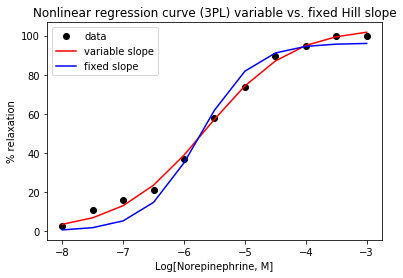

In [116]:
# let's plot both curves on the same graph
plt.plot(norepi_log, relaxation, 'ko', label='data') # original data points

plt.plot(norepi_log, results_1.best_fit, 'r-', label='variable slope')
plt.plot(norepi_log, results_2.best_fit, 'b-', label='fixed slope')

plt.title("Nonlinear regression curve (3PL) variable vs. fixed Hill slope")
plt.xlabel("Log[Norepinephrine, M]")
plt.ylabel("% relaxation")
plt.legend();

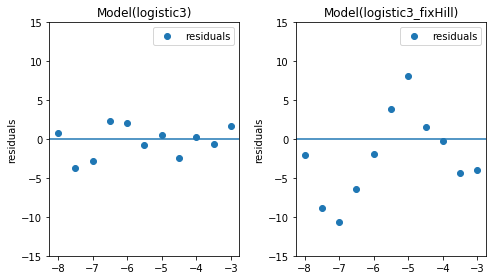

In [117]:
# let's have a look at the residuals
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
results_1.plot_residuals()
plt.ylim(-15,15)
plt.subplot(1,2,2)
results_2.plot_residuals() # looks like we show the distance of the curve from the point
plt.ylim(-15,15)
plt.tight_layout();

In [118]:
results_1.residual

array([ 0.81522906, -3.74228399, -2.84946779,  2.3506351 ,  2.03502154,
       -0.74465642,  0.57540269, -2.49058172,  0.264254  , -0.59534315,
        1.72876687])

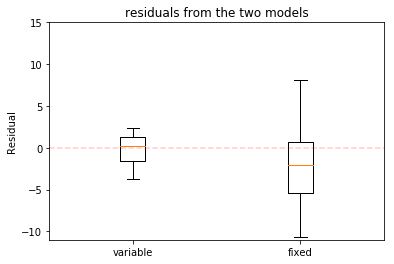

In [119]:
plt.boxplot([results_1.residual, results_2.residual])
plt.xticks([1,2], ['variable', 'fixed'])
plt.ylabel("Residual")
plt.title("residuals from the two models")
plt.ylim(-11, 15)
plt.axhline(0, linestyle='--', color='red', alpha=.2);

H0 is that the simpler model is correct. In fact the alternative model fits much better (lower sum of squares) but has one fewer df. The calculations balance the difference in df with the difference in SS.

Hypothesis | Scatter from | Sum of squares | df
---|---|---|---
Null | Fixed slope | 358.1 | 9
Alternative | Variable slope | 43.0 | 8
Difference | Improvement | 315.1 | 1

In [121]:
print(f"Sum of squares for the fixed slope model: {np.sum(results_2.residual**2):4.1f}")
print(f"Degrees of freedom for the fixed slope model: {len(x) - len(results_2.params)}")
print(f"Sum of squares for the variable slope model: {np.sum(results_1.residual**2):4.1f}")
print(f"Degrees of freedom for the variable slope model: {len(x) - len(results_1.params)}")

Sum of squares for the fixed slope model: 358.1
Degrees of freedom for the fixed slope model: 9
Sum of squares for the variable slope model: 43.0
Degrees of freedom for the variable slope model: 8


Computing an F ratio and P value from the fits of the 2 models

Source of variation | Sum of squares | DF | MS | F ratio | P value
---|---|---|---|---|---
Difference | 315.1 | 1 | 315.1 | 58.6 | <0.0001
Variable slope model | 43.0 | 8 | 5.4 |
Fixed slope model |358.1 | 9

In [125]:
MS_diff = (np.sum(results_2.residual**2) - np.sum(results_1.residual**2)) / (
(len(x) - len(results_2.params)) - (len(x) - len(results_1.params)))

In [129]:
MS_variable = np.sum(results_1.residual**2) / (len(x) - len(results_1.params))

In [130]:
F_ratio = MS_diff / MS_variable
print(f"F ratio : {F_ratio}")

F ratio : 58.68968193213107


In [132]:
dfn, dfd = 1, 8
p_value= 1 - stats.f(dfn, dfd).cdf(F_ratio)
print(f"P values computed from the F ratio distribution: {p_value:5.5f}")

P values computed from the F ratio distribution: 0.00006


If the fixed-slope model were correct, it is possible that random scatter of points made the curve fit so badly, but since the P value is less than 0.0001, this would happen less than 0.01% of the time. The low P value is strong evidence that the simple model is inadequate, and that more complicated model in which the program fits the Hill slope is preferable.